In [90]:
!pip install pandas
!pip install matplotlib seaborn
!pip install scipy
!pip install numpy
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d

import sys
import os


# Add parent directory to sys.path
sys.path.append(os.path.abspath('..'))



# Load your CSV
df = pd.read_csv("../GPU_DATA.csv")

# Axis Label
df["LABEL"] = df["YEAR"].astype(str) + " - " + df["GPU"]

# TDP per transistor
df["TDP_PER_TRANSISTOR"] = df["TDP_MAX"] / df["TRANSISTOR_COUNT"]


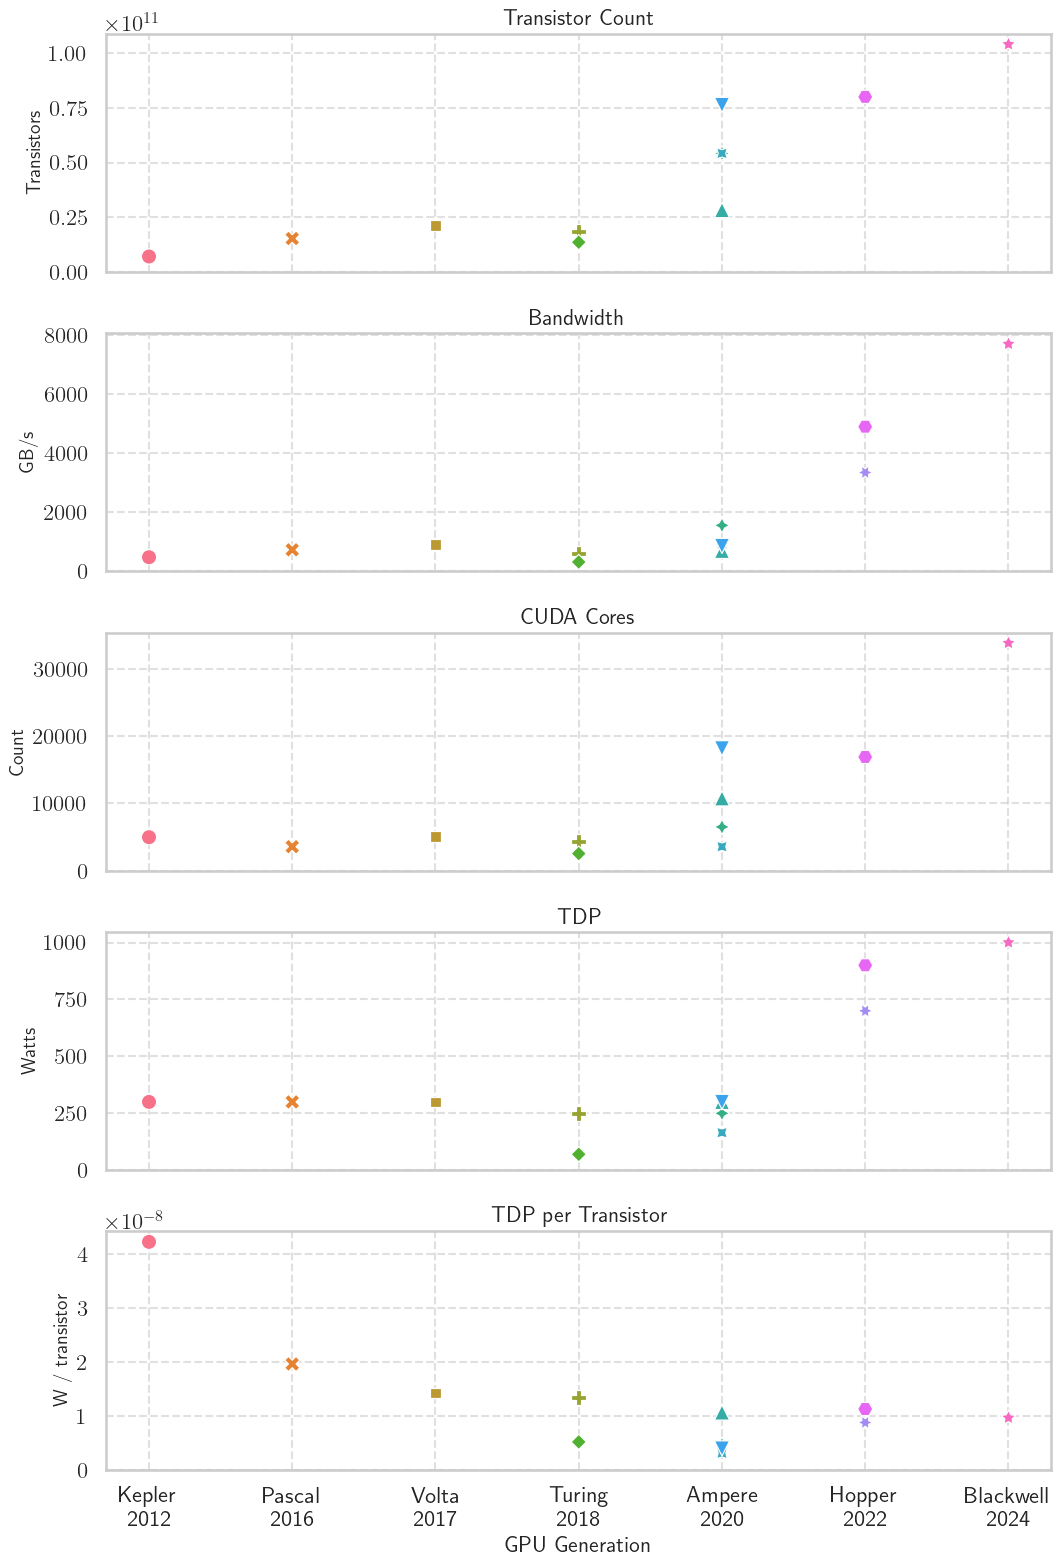

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define mapping and order ---
generation_map = {
    'K80': 'Kepler',
    'P100': 'Pascal',
    'V100_SXM': 'Volta',
    'T4': 'Turing',
    '2080ti': 'Turing',
    'A30': 'Ampere',
    'A40': 'Ampere',
    'A100(40)_PCIE': 'Ampere',
    'L40': 'Ampere',
    'H100_SXM': 'Hopper',
    'GH200': 'Hopper',
    'B200_HGX': 'Blackwell'
}

generation_year = {
    'Kepler': 2012,
    'Pascal': 2016,
    'Volta': 2017,
    'Turing': 2018,
    'Ampere': 2020,
    'Hopper': 2022,
    'Blackwell': 2024,

}

generation_order = ['Kepler', 'Pascal', 'Volta', 'Turing', 'Ampere', 'Hopper', 'Blackwell']

# --- Map and convert ---
df["GENERATION"] = df["GPU"].map(generation_map)
df["GENERATION"] = pd.Categorical(df["GENERATION"], categories=generation_order, ordered=True)

# --- Sort ---
df_sorted = df.sort_values("GENERATION")

# --- Plot setup ---
sns.set_theme(style="whitegrid", context="talk")

fig, axes = plt.subplots(5, 1, figsize=(11, 16), sharex=True)

metrics = [
    ("TRANSISTOR_COUNT", "Transistor Count", "Transistors"),
    ("BANDWIDTH", "Bandwidth", "GB/s"),
    ("CUDA_CORES", "CUDA Cores", "Count"),
    ("TDP_MAX", "TDP", "Watts"),
    ("TDP_PER_TRANSISTOR", "TDP per Transistor", "W / transistor")
]

# --- Plot ---
for ax, (col, title, ylabel) in zip(axes, metrics):
    sns.scatterplot(
        data=df_sorted,
        x="GENERATION", y=col,
        hue="GPU",
        style="GPU",
        s=120,
        ax=ax
    )
    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.legend_.remove()

# Create combined labels: "Generation – Year"
xtick_labels = [f"{gen} \n {generation_year[gen]}" for gen in generation_order]

# Update x-ticks on the last subplot (shared x-axis)
axes[-1].set_xticks(range(len(generation_order)))
axes[-1].set_xticklabels(xtick_labels)
axes[-1].set_xlabel("GPU Generation", fontsize=16)
axes[-1].tick_params(axis='x', rotation=0)	

for ax in axes[:-1]:
    ax.set_xlabel("")

plt.tight_layout(h_pad=1)
plt.savefig("gpu_trends_by_generation.svg", bbox_inches='tight')
plt.show()




In [93]:
# Calculates the speed of of each generation after the earliest year

for col in ["FP16", "FP32", "FP64"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna()

earliest_year = df["YEAR"].min()

for col in ["FP16", "FP32", "FP64"]:
    baseline = df.loc[df["YEAR"] == earliest_year, col].values[0]
    df[f"{col}_speedup"] = df[col] / baseline

# Calculate FP value per watt
for col in ["FP16", "FP32", "FP64"]:
    # per watt metric
    df[f"{col}_per_w"] = df[col] / df["TDP_MAX"]
    
    # baseline per watt at earliest year
    baseline_per_w = df.loc[df["YEAR"] == df["YEAR"].min(), f"{col}_per_w"].values[0]
    
    # improvement factor (speedup relative to baseline per watt)
    df[f"{col}_per_w_speedup"] = df[f"{col}_per_w"] / baseline_per_w


cols = ["GPU", "FP16", "FP32", "FP64", "TDP_MAX", "FP16_per_w_speedup", "FP32_per_w_speedup", "FP64_per_w"]
print(df[cols].to_string())

              GPU    FP16     FP32     FP64  TDP_MAX  FP16_per_w_speedup  FP32_per_w_speedup  FP64_per_w
0        H100_SXM  248.30   67.000  34.0000      700            5.586052            3.014307    0.048571
1        V100_SXM   28.26   14.130   7.0660      300            1.483465            1.483309    0.023553
2   A100(40)_PCIE   77.97   19.490   9.7460      250            4.911496            2.455175    0.038984
3        B200_HGX  496.60  124.160  62.0800     1000            7.820472            3.910141    0.062080
4             A40   37.42   37.420   0.5840      300            1.964304            3.928197    0.001947
5          2080ti   26.90   13.450   0.4202      250            1.694488            1.694310    0.001681
6            P100   19.05    9.526   4.7630      300            1.000000            1.000000    0.015877
8              T4   65.13    8.141   0.2544       70           14.652418            3.662608    0.003634
9             A30   10.32   10.320   5.1610      165   

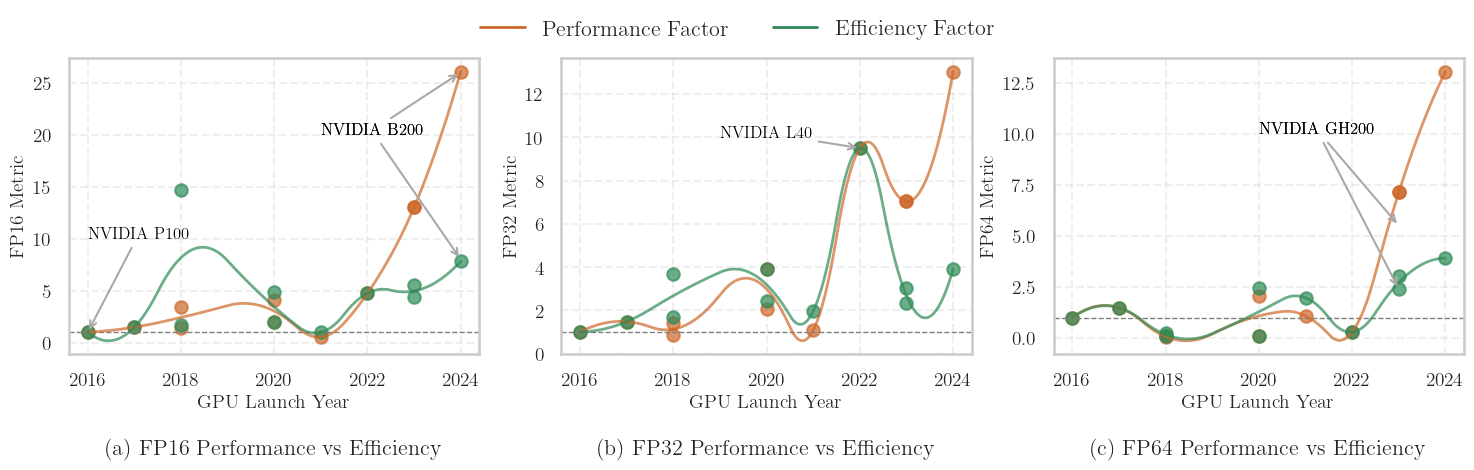

In [94]:

# Set LaTeX font globally
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

colors = {
    "speedup": "#CE682A",
    "per_w_speedup": "#2E8B57"
}

labels = {
    "speedup": "Performance Factor",
    "per_w_speedup": "Efficiency Factor"
}

letters = ['a', 'b', 'c']

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)


for i, col in enumerate(["FP16", "FP32", "FP64"]):
    ax = axes[i]
    ax.axhline(1, color="gray", linestyle="--", linewidth=1)
    
    for metric, color in colors.items():
        col_name = f"{col}_{metric}"
        
        # Scatter all data
        ax.scatter(df["YEAR"], df[col_name], color=color, alpha=0.7)
        
        # Average values for each year
        df_avg = df.groupby("YEAR")[col_name].mean().reset_index()
        
        # Smooth curve
        x_new = np.linspace(df_avg["YEAR"].min(), df_avg["YEAR"].max(), 1000)
        spline = interp1d(df_avg["YEAR"], df_avg[col_name], kind='quadratic')
        y_smooth = spline(x_new)
        
        ax.plot(x_new, y_smooth, color=color, linewidth=2, alpha=0.7)

    if i == 0:
        ax.annotate(
            "NVIDIA B200",        # Text to show
            xy=(2024, 26),             # Point to annotate (x, y)
            xytext=(2021, 20),         # Position of the text
            arrowprops=dict(arrowstyle="->", color='darkgray', lw=1.5),
            fontsize=12,
            color='black'
        )
        ax.annotate(
            "NVIDIA B200",        # Text to show
            xy=(2024, 8),             # Point to annotate (x, y)
            xytext=(2021, 20),         # Position of the text
            arrowprops=dict(arrowstyle="->", color='darkgray', lw=1.5),
            fontsize=12,
            color='black'
        ) 
        ax.annotate(
            "NVIDIA P100",        # Text to show
            xy=(2016, 1),             # Point to annotate (x, y)
            xytext=(2016, 10),         # Position of the text
            arrowprops=dict(arrowstyle="->", color='darkgray', lw=1.5),
            fontsize=12,
            color='black'
        )
        
    if i == 1:
        ax.annotate(
            "NVIDIA L40",        # Text to show
            xy=(2022, 9.5),             # Point to annotate (x, y)
            xytext=(2019, 10),         # Position of the text
            arrowprops=dict(arrowstyle="->", color='darkgray', lw=1.5),
            fontsize=12,
            color='black'
        )
    
    if i == 2:
        ax.annotate(
            "NVIDIA GH200",        # Text to show
            xy=(2023, 2.4),             # Point to annotate (x, y)
            xytext=(2020, 10),         # Position of the text
            arrowprops=dict(arrowstyle="->", color='darkgray', lw=1.5),
            fontsize=12,
            color='black'
        )

        ax.annotate(
            "NVIDIA GH200",        # Text to show
            xy=(2023, 5.5),             # Point to annotate (x, y)
            xytext=(2020, 10),         # Position of the text
            arrowprops=dict(arrowstyle="->", color='darkgray', lw=1.5),
            fontsize=12,
            color='black'
        )

    ax.set_xlabel("GPU Launch Year")  # title at bottom
    #ax.set_xlabel(f"({letters[i]}) {col} Performance vs Efficiency")  # title at bottom
    ax.set_ylabel(f"{col} Metric")
    
    # Lighter grid lines
    ax.grid(True, linestyle='--', alpha=0.3)

    ax.text(
        0.5, -0.32,                 # x in axes fraction, y below axis
        f"({letters[i]}) {col} Performance vs Efficiency",
        ha='center', va='center', transform=ax.transAxes,
        fontsize=16
    )

# Combined legend at the top
handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors.values()]
fig.legend(handles, labels.values(), loc='upper center', ncol=len(labels), frameon=False, fontsize=16)

plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.3)  # top moves legend away, wspace moves subplots apart

plt.savefig("fp_over_time_all.svg", bbox_inches='tight')
plt.show()

In [95]:
from lifecycle.compare import compare_gpus, calculate_intersect, float_to_days
import lifecycle.constants as constants

def safe_intersect_to_days(old_opex, new_opex):
    intersect = calculate_intersect(old_opex, new_opex)

    if not intersect:  # handles False, None, empty tuple
        return None  

    year_fraction = intersect[0]  # first element of tuple

    if year_fraction < 0:
        return None

    return float_to_days(year_fraction)

def days_to_years(days):
    """Convert days to years (assuming 365 days per year)."""
    if days is None:
        return None
    return days / 30.4375


(np.float64(5.469046860261912), np.float64(1088.4904915784568))


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]


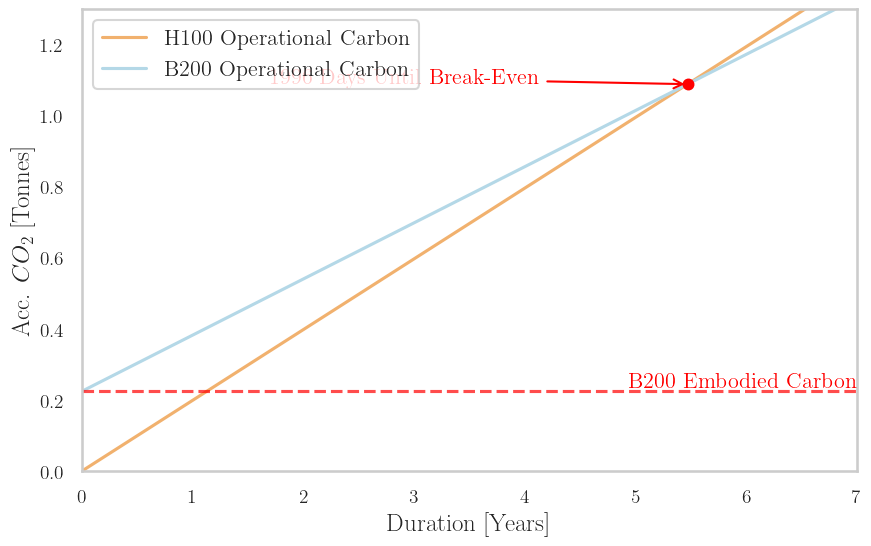

In [96]:
from matplotlib.ticker import MaxNLocator

SCALING = constants.SCALING_EMISSIONS
NAME = 'SCALING_EMISSIONS'

#SCALING = constants.SCALING_UTILIZATION
#NAME = 'SCALING_UTILIZATION'

comparison = compare_gpus(df, "H100_SXM", "B200_HGX", constants.FP64, "Sweden", 75, 75, SCALING)

TIME = 8

# Convert from kg → tonnes
old_opex = [v / 1000 for v in comparison.get("oldSystemOpex")][:TIME]
new_opex = [v / 1000 for v in comparison.get("newSystemOpex")][:TIME]

# Intersection (in days → years)
intersect = calculate_intersect(comparison.get("oldSystemOpex"), comparison.get("newSystemOpex"))
intersect_days = safe_intersect_to_days(comparison.get("oldSystemOpex"), comparison.get("newSystemOpex")) 

print(intersect)

if intersect_days is not None:
    x_intersect, y_intersect = intersect
    y_intersect /= 1000  # kg → tonnes


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 18,
    "axes.titlesize": 14,
    "legend.fontsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

plt.figure(figsize=(10, 6))  # 10 inches wide, 6 inches tall
# Plot OPEX lines
plt.plot(old_opex, label="H100 Operational Carbon", color="#F1B16E")
plt.plot(new_opex, label="B200 Operational Carbon", color="#B4D8E7")

# Force axis to start at (0,0)
plt.xlim(left=0)
plt.ylim(bottom=0, top=1.3)
plt.xlim(right=TIME-1)

# Add horizontal line for embodied carbon (y-intercept of new GPU curve)
embodied_carbon = new_opex[0]
plt.axhline(embodied_carbon, color="red", linestyle="--", alpha=0.7)
plt.text(
    len(new_opex) - 1, embodied_carbon, 
    "B200 Embodied Carbon", 
    color="red", 
    va="bottom", ha="right", fontsize=16
)

# Add intersection marker + label
if intersect_days is not None:
    plt.scatter(x_intersect, y_intersect, color="red", zorder=5, s=50)
    plt.annotate(
        f"{intersect_days:.0f} Days Until Break-Even",
        xy=(x_intersect, y_intersect),
        xytext=(-300, 0),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="red"),
        fontsize=16,
        color="red",
    )

# Labels and formatting
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Duration [Years]")
plt.ylabel("Acc. $CO_2$ [Tonnes]")
plt.legend(loc='upper left')
plt.grid(False)

plt.savefig(f"comparison_{NAME}.svg", bbox_inches='tight')
plt.show()

In [97]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_scaled_utilization(current, new, workload, current_utilization):
    curr_perf = df.loc[df["GPU"] == current, workload].values[0]
    new_perf = df.loc[df["GPU"] == new, workload].values[0]
    ratio = curr_perf / new_perf

    scaled_utilization = min(100, (current_utilization * ratio))

    #if (current == "P100") and (new == "B200_HGX"):
    #    print(current, curr_perf, new, new_perf, scaled_utilization)

    return scaled_utilization

def plot_gpu_breakeven(df, workload, country, scaling):

    filtered_df = df[df[workload].notnull()]
    
    # Sort GPUs by year
    gpus = filtered_df.sort_values(by="YEAR", ascending=True)["GPU"].tolist()
    
    # Build pairwise breakeven times
    data = {}
    for current in gpus:
        row = {}
        for new in gpus:

            curr_generation = generation_order.index(generation_map[current])
            new_generation = generation_order.index(generation_map[new])

            # dont want to downgrade a generation
            if (curr_generation > new_generation):
                continue


            cur_perf_null = df.loc[df["GPU"] == current, workload].values[0] == 0
            new_perf_null = df.loc[df["GPU"] == new, workload].values[0] == 0

            if (cur_perf_null or new_perf_null):
                row[new] = 1000
                continue

            curr_utilization, new_utilization = 75, 75

            if scaling == constants.SCALING_UTILIZATION:
                new_utilization = calculate_scaled_utilization(current, new, workload, curr_utilization)

            comparison = compare_gpus(df, current, new, workload, country, curr_utilization, new_utilization, scaling)

            days = days_to_years(safe_intersect_to_days(
                comparison.get("oldSystemOpex"),
                comparison.get("newSystemOpex")
            ))



            row[new] = 0.0001 if days is None else days

        data[current] = row

    # Convert to DataFrame and transpose so rows=current, cols=new
    times = pd.DataFrame(data).T
    times = times.apply(pd.to_numeric, errors='coerce')

    # Mask diagonal
    mask = np.eye(times.shape[0], dtype=bool)

    plt.figure(figsize=(8,7))

    # Base heatmap
    sns.heatmap(
        times,
        annot=True,
        fmt=".0f",
        cmap='crest',
        vmin=0,
        vmax=60,
        cbar=True,
        linewidths=0.5,
        linecolor='white'
    )

    special_value = 0.0001

    # Highlight special values (e.g., -1) in red if specified
    if special_value is not None:
        for i in range(times.shape[0]):
            for j in range(times.shape[1]):
                if i == j:
                    continue
                if times.iloc[i, j] == special_value:
                    plt.gca().add_patch(
                        plt.Rectangle(
                            (j, i), 1, 1, fill=True, color='red', alpha=0.6, linewidth=0.5, edgecolor='white'
                        )
                    )

    for i in range(times.shape[0]):
        plt.gca().add_patch(
            plt.Rectangle(
                (i, i), 1, 1, fill=True, color='lightgray', alpha=0.8
            )
        )


    # Labels & styling
    plt.title(f"{workload} | {country} | {constants.get_scaling_string(scaling)} | (Months)", pad=20)
    plt.xlabel("New GPU", labelpad=12)
    plt.ylabel("Current GPU")
    plt.gca().xaxis.set_label_position('top')
    plt.gca().xaxis.tick_top()
    plt.xticks(rotation=45, ha='left')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


Generating heatmap for workload=FP16, scaling=Utilization Scaling, country=Ireland


/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


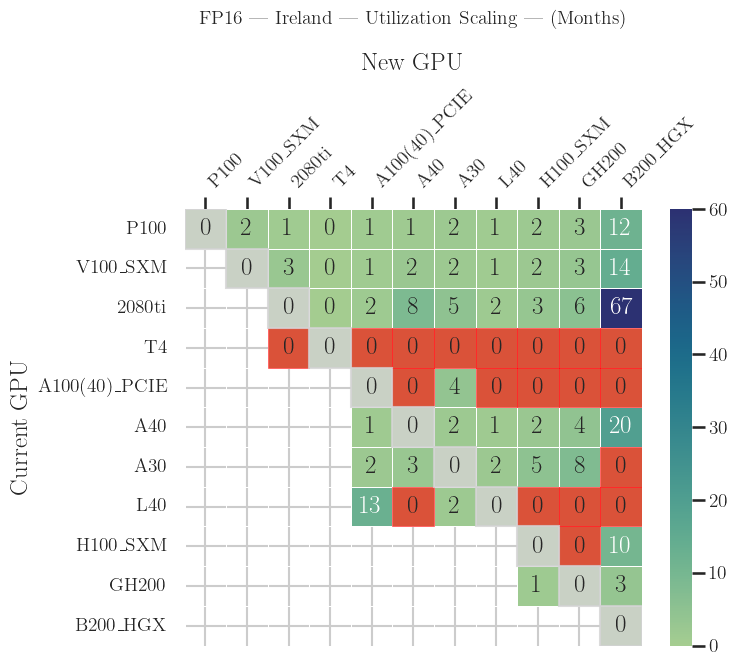

Generating heatmap for workload=FP16, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


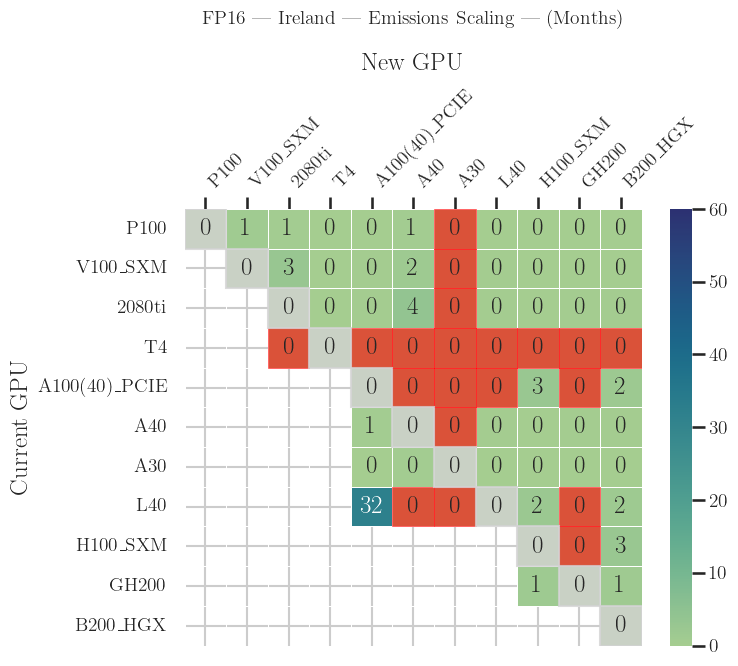

Generating heatmap for workload=FP32, scaling=Utilization Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


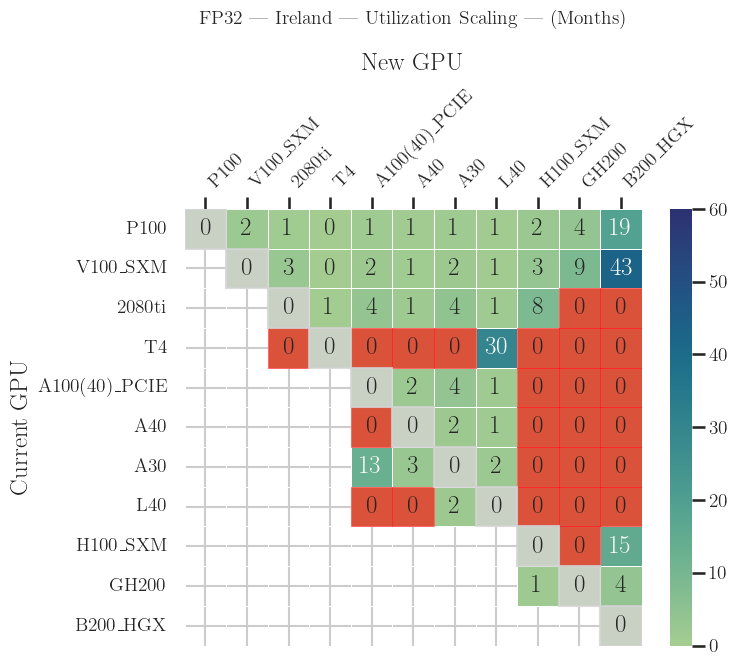

Generating heatmap for workload=FP32, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


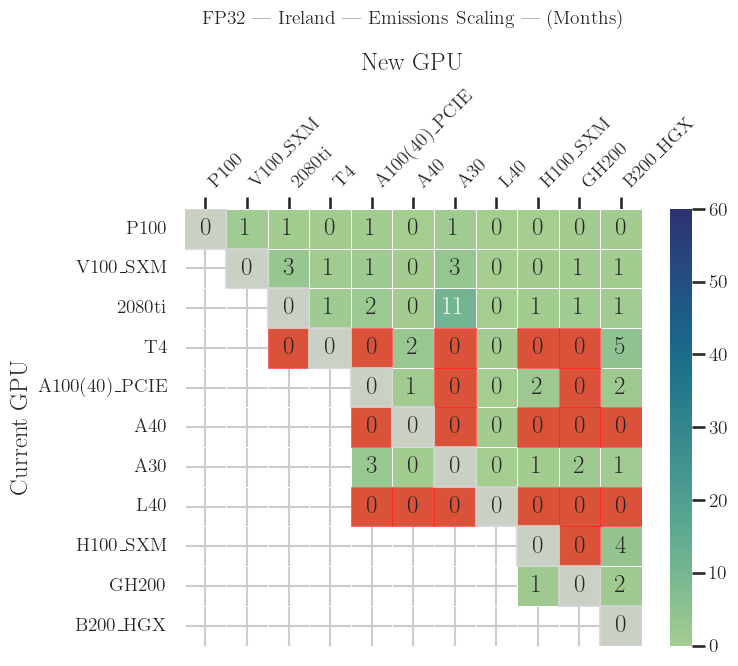

Generating heatmap for workload=FP64, scaling=Utilization Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


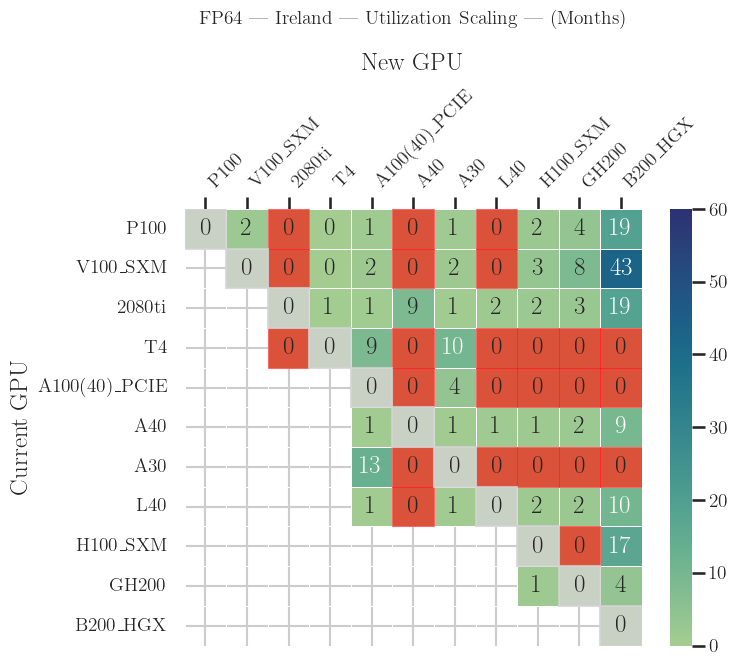

Generating heatmap for workload=FP64, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


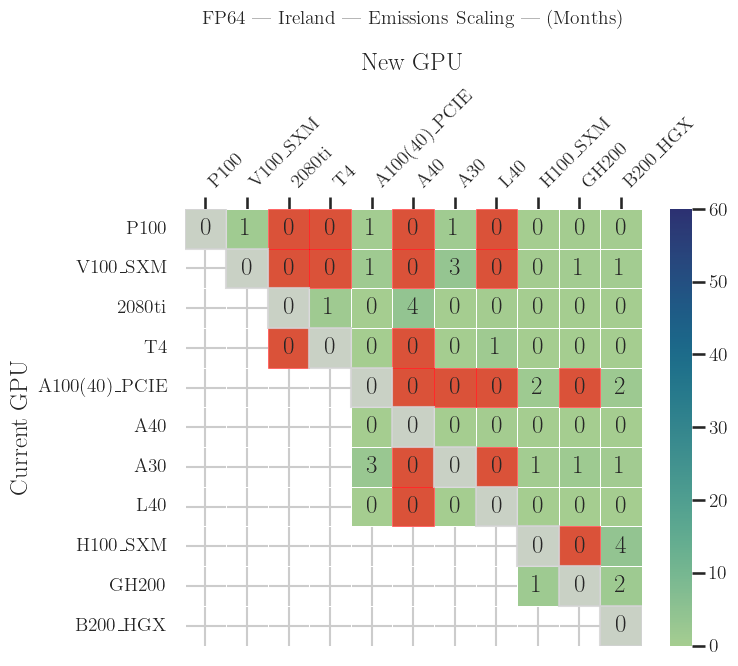

Generating heatmap for workload=BENCH_MULT_FP16_TFLOPS, scaling=Utilization Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


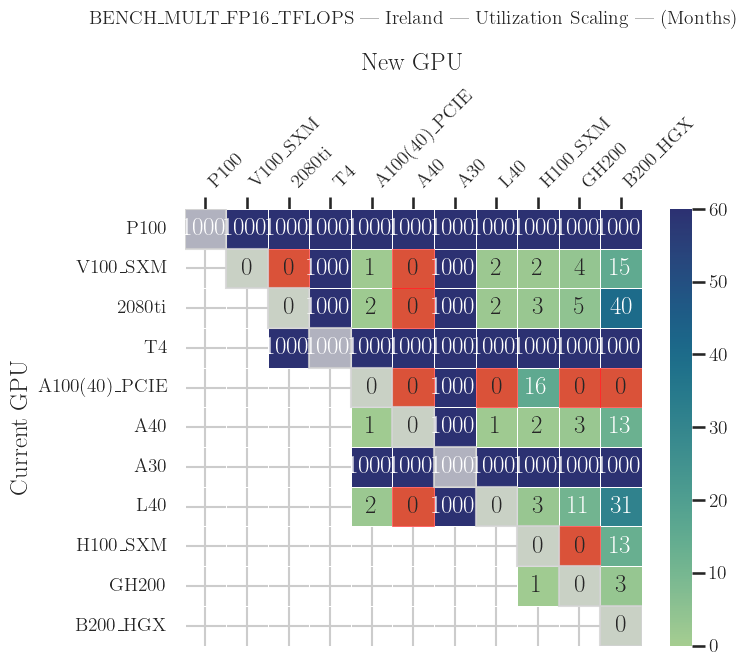

Generating heatmap for workload=BENCH_MULT_FP16_TFLOPS, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


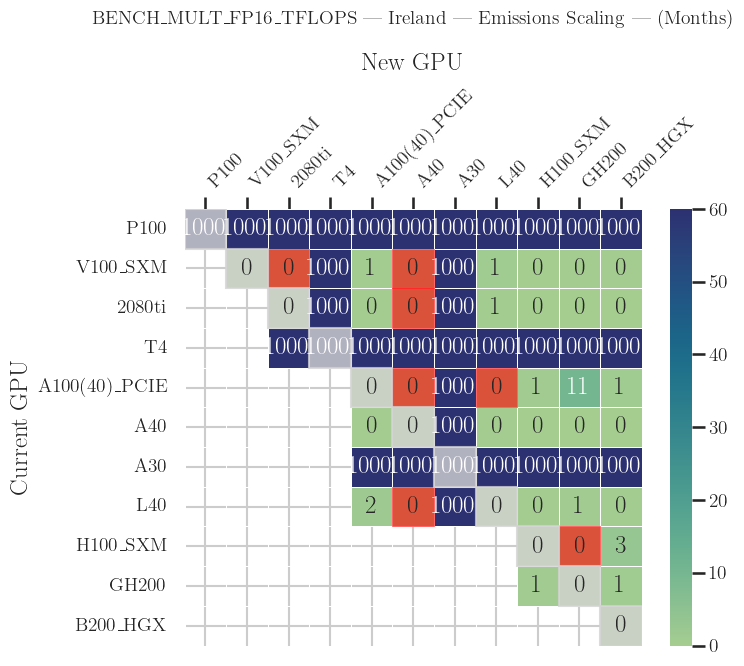

Generating heatmap for workload=BENCH_MULT_FP32_TFLOPS, scaling=Utilization Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


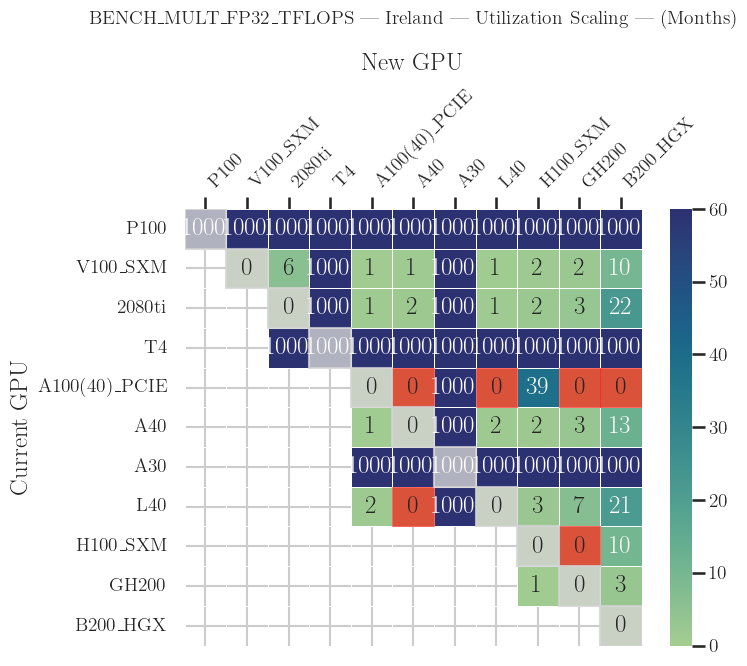

Generating heatmap for workload=BENCH_MULT_FP32_TFLOPS, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


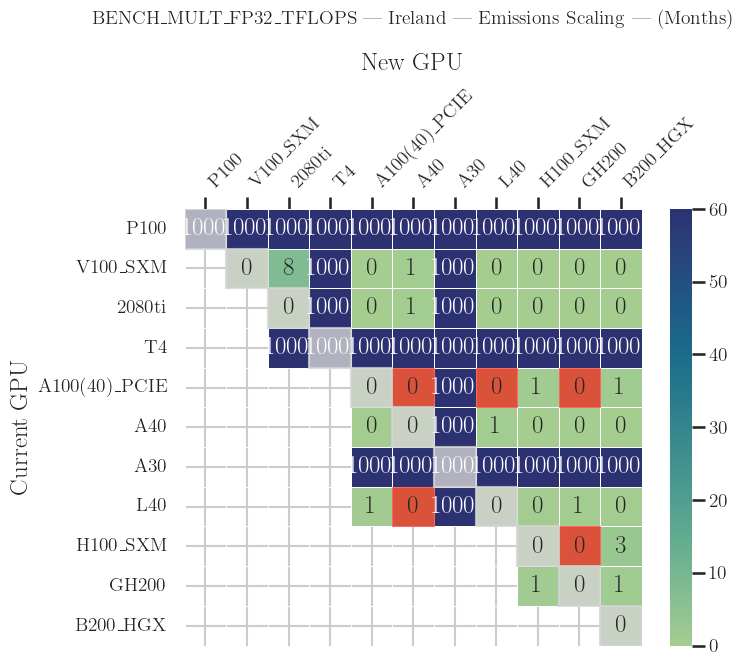

Generating heatmap for workload=BENCH_MULT_FP64_TFLOPS, scaling=Utilization Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


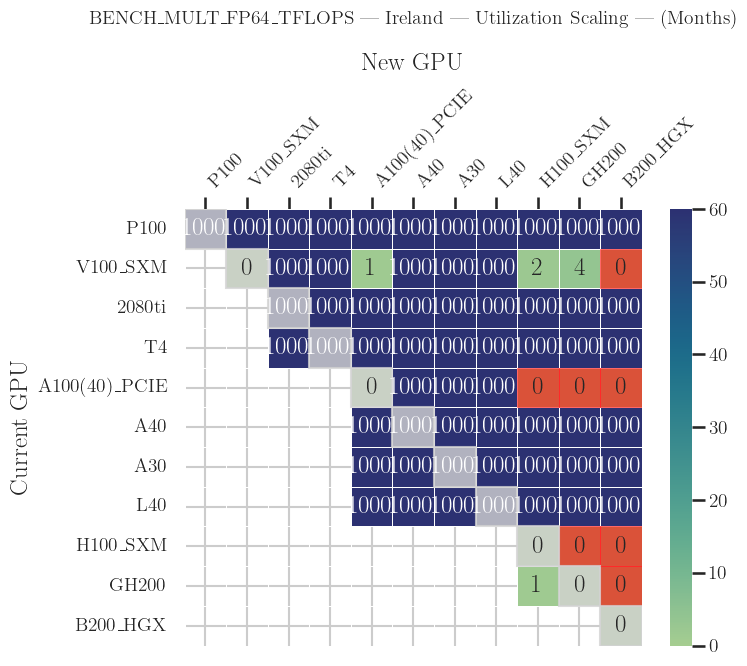

Generating heatmap for workload=BENCH_MULT_FP64_TFLOPS, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


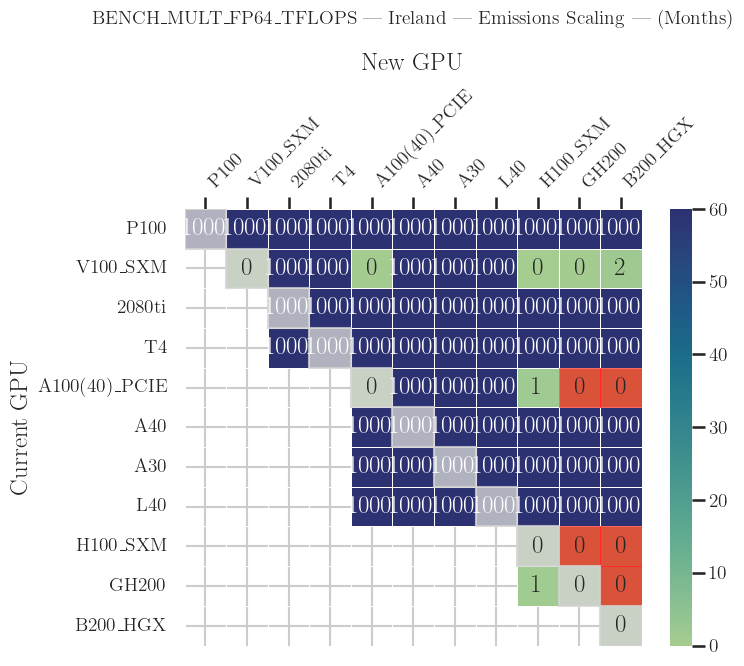

Generating heatmap for workload=MKEYS/S_SORT, scaling=Utilization Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


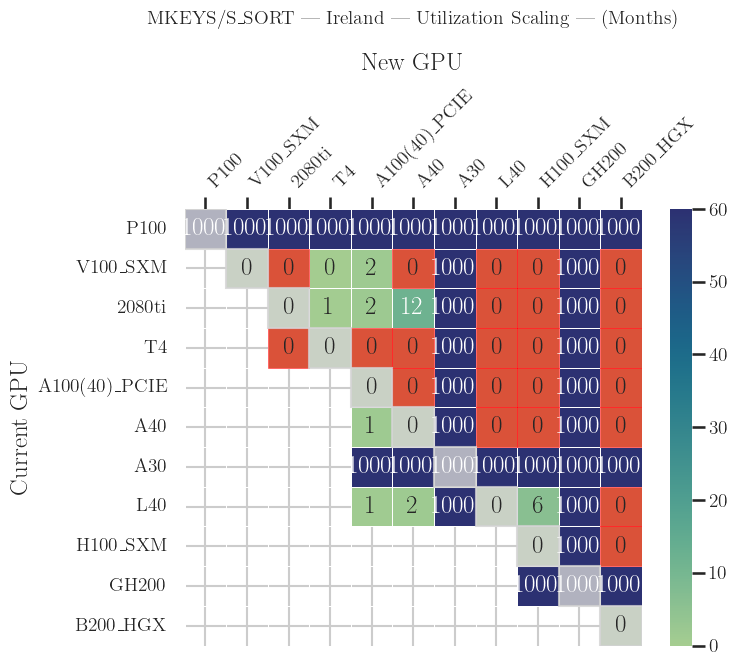

Generating heatmap for workload=MKEYS/S_SORT, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


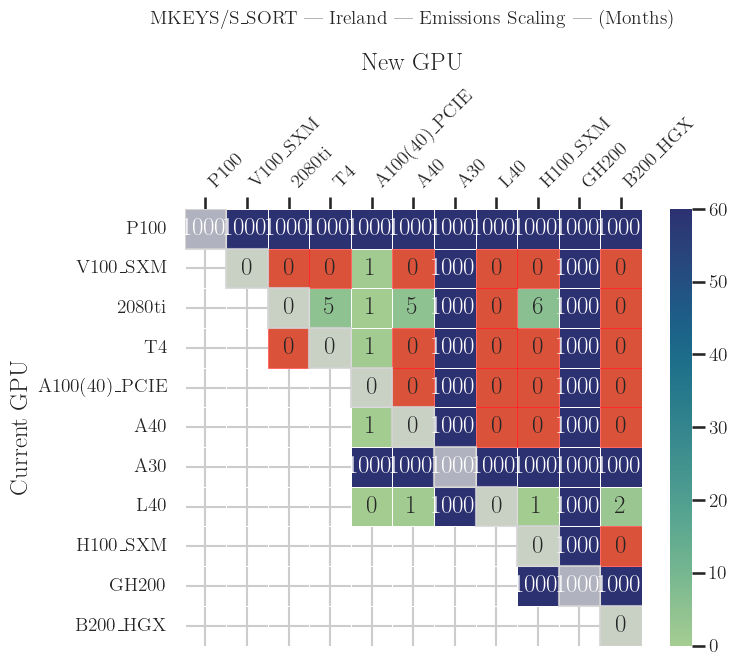

Generating heatmap for workload=TCPxAIUCpm@10.0, scaling=Utilization Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


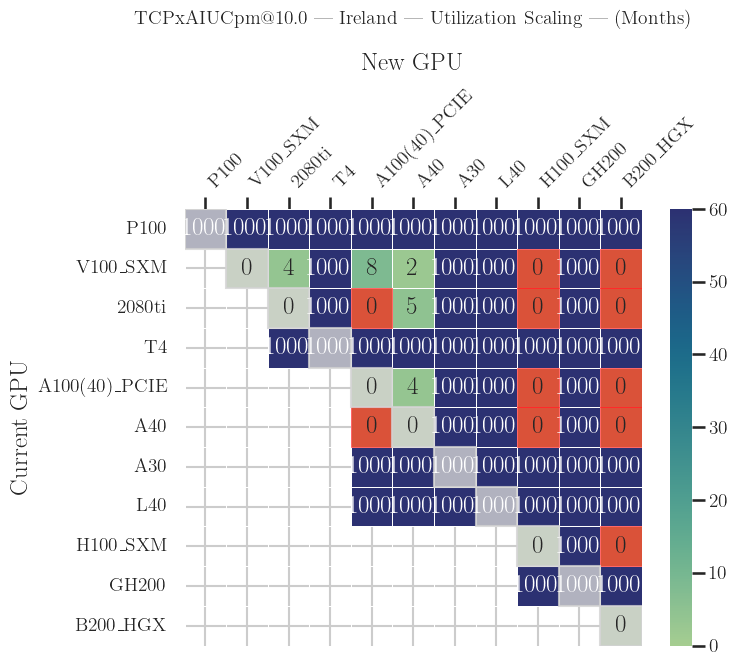

Generating heatmap for workload=TCPxAIUCpm@10.0, scaling=Emissions Scaling, country=Ireland


/Users/mbaeuerl/coding/sdm-project-sose25/lifecycle/compare.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = [new_opex / old_opex for new_opex, old_opex in zip(new_system_opex, old_system_opex)]
/var/folders/lj/h51l3dnn1sjglc06hrjdzqrc0000gn/T/ipykernel_73677/3862993606.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


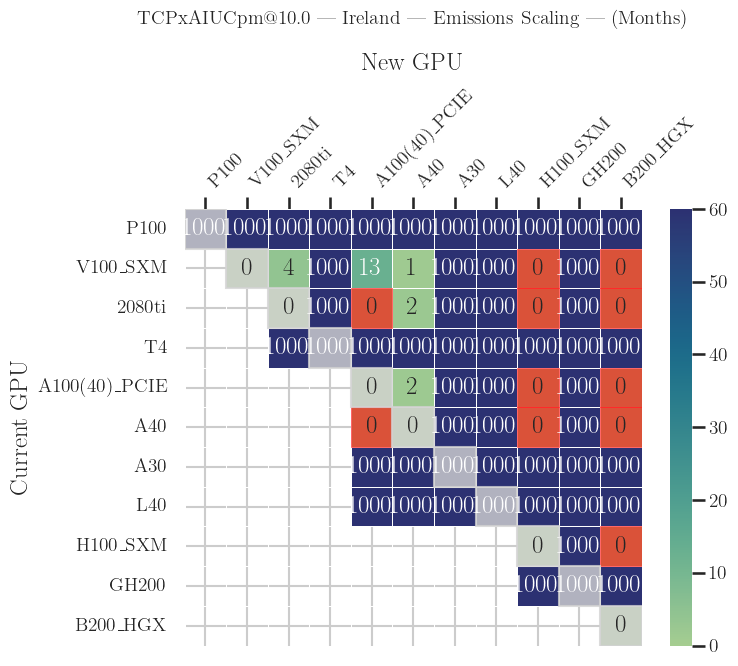

In [98]:
workloads = [constants.FP16, constants.FP32, constants.FP64, constants.MMULT_16, constants.MMULT_32, constants.MMULT_64, constants.SORTING, constants.TPCXAI]

scaling_options = [constants.SCALING_UTILIZATION, constants.SCALING_EMISSIONS]

country = "Ireland"


for workload in workloads:
    for scaling in scaling_options:
        print(f"Generating heatmap for workload={workload}, scaling={constants.get_scaling_string(scaling)}, country={country}")
        plot_gpu_breakeven(
            df=df,
            workload=workload,
            scaling=scaling,
            country=country
        )